In [ ]:
import os
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import random

Instructions for updating:
non-resource variables are not supported in the long term


# SVAE Class

In [ ]:
class SVAE:
    
    def __init__(
        self, checkpoint_dir, log_dir, img_shape=(32, 32, 1),
        num_latents=32, num_classes=10):
        
        self.checkpoint_dir = checkpoint_dir
        self.img_shape = img_shape
        self.num_latents = num_latents
        self.num_classes = num_classes
        
        with tf.compat.v1.variable_scope('svae', reuse=tf.compat.v1.AUTO_REUSE):
            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            self._create_network()
            self._create_losses()
            self._create_optimizers()
            self._create_metrics()
            self._create_summaries()
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

        self._load_checkpoint()
        self.summary_writer = tf.summary.FileWriter(log_dir, self.sess.graph)
        self.best_val_acc = -float('inf')
        self.best_val_recon_loss = float('inf')
        
    def _load_checkpoint(self):
        """
        Checks if a model checkpoint exists, and if so, alters 'self.sess' to
        reflect the appropriate state of the Tensorflow computation graph.
        """
        self.saver = tf.train.Saver(max_to_keep=5)
        checkpoint = tf.train.get_checkpoint_state(self.checkpoint_dir)

        # If checkpoint exists and is reachable, load checkpoint state into 'sess'
        if checkpoint and checkpoint.model_checkpoint_path:
                self.saver.restore(self.sess, checkpoint.model_checkpoint_path)
                print('loaded checkpoint: {}'.format(
                    checkpoint.model_checkpoint_path))
        else:
                print(
                        'Could not find old checkpoint. '
                        'Creating new checkpoint directory.'
                )
                if not os.path.exists(self.checkpoint_dir):
                        os.mkdir(self.checkpoint_dir)
                
    def _save_checkpoint(self):
        print('checkpointing: {}'.format(self.checkpoint_dir))
        self.saver.save(
            self.sess,
            self.checkpoint_dir,
            global_step=self.global_step)
                        
    def _create_encoder_network(self, x, reuse=tf.compat.v1.AUTO_REUSE):
        """
        Create computation graph that returns output tensors of the recognition
        network: a tensor of means and a tensor of log standard deviations that
        define the factorized latent distribution q(z).
        """
        with tf.compat.v1.variable_scope('encoder', reuse=reuse):
            # If input images were reshaped into vectors, reshape them back into
            # their original dimensions for convolutional layers.
            # height, width, channels = self.img_shape
            # x_reshaped = tf.reshape(x, [-1, height, width, channels])

            # Ex: filters=32, kernel_size=4, stride=2
            x = tf.layers.Conv2D(32, 4, 2, 'same', activation=tf.nn.relu,)(x)
            x = tf.layers.BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-5)(x)
            x = tf.layers.Conv2D(64, 4, 2, 'same', activation=tf.nn.relu,)(x)
            x = tf.layers.BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-5)(x)
            x = tf.layers.Conv2D(128, 4, 2, 'same', activation=tf.nn.relu,)(x)
            x = tf.layers.BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-5)(x)
            x = tf.layers.Conv2D(128, 4, activation=tf.nn.relu,)(x)
            x = tf.layers.BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-5)(x)
            # Final convolutions downsize each channels' dimensions to a 1x1 patch,
            # resulting in a final tensors with shape (batch_size, 1, 1, num_latents)
            z_mean = tf.layers.Conv2D(self.num_latents, 1)(x)

            # log_sigma used for numerical stability
            z_log_sigma = tf.layers.Conv2D(self.num_latents, 1)(x)

            # Reshape outputs to remove extra dimensions. This is necessary
            # for the _sample_z function.
            z_mean = tf.reshape(
                z_mean, shape=(-1, self.num_latents), name='z_mean')
            z_log_sigma = tf.reshape(
                z_log_sigma, shape=(-1, self.num_latents), name='z_log_sigma')

            return (z_mean, z_log_sigma)
        
    def _create_decoder_network(self, z, reuse=tf.compat.v1.AUTO_REUSE):
        """
        Create computation graph that accepts tensors for sampled latent vectors
        and returns output logit tensors. Activations for these output logits are
        applied separately when creating the full autoencoder network and loss
        corresponding loss function.
        """
        with tf.compat.v1.variable_scope('decoder', reuse=reuse):
            # A mini-batch of sampled latent vectors has shape
            # (batch_size, num_latents) and need to be reshaped into num_latents
            # 1x1 channels
            z = tf.reshape(z, shape=(-1, 1, 1, self.num_latents))

            # Ex: filters=32, kernel_size=1, stride=1
            z = tf.layers.Conv2DTranspose(
                128, 1, 1, 'valid', activation=tf.nn.relu,)(z)
            z = tf.layers.BatchNormalization(
                axis=-1, momentum=0.1, epsilon=1e-5)(z)
            z = tf.layers.Conv2DTranspose(
                128, 4, 1, 'valid', activation=tf.nn.relu,)(z)
            z = tf.layers.BatchNormalization(
                axis=-1, momentum=0.1, epsilon=1e-5)(z)
            z = tf.layers.Conv2DTranspose(
                64, 4, 2, 'same', activation=tf.nn.relu,)(z)
            z = tf.layers.BatchNormalization(
                axis=-1, momentum=0.1, epsilon=1e-5)(z)
            z = tf.layers.Conv2DTranspose(
                128, 4, 2, 'same', activation=tf.nn.relu,)(z)
            z = tf.layers.BatchNormalization(
                axis=-1, momentum=0.1, epsilon=1e-5)(z)
            x = tf.layers.Conv2DTranspose(
                self.img_shape[-1], 4, 2, 'same', activation=None,)(z)

            x_out_logit = tf.identity(x, name='x_out_logit')

            return x_out_logit
        
    def _sample_z(self, z_mean, z_log_sigma):
        """
        Reparametrization trick to sample from latent distribution.
        sample = mean + standard_deviation * gaussian_noise 
        where gaussian_noise ~ N(0, 1)
        """
        eps_shape = tf.shape(z_mean)
        eps = tf.random_normal(eps_shape, 0, 1, dtype=tf.float32 )

        # z = mu + sigma * epsilon
        z = tf.add(z_mean,
                             tf.multiply(tf.exp(z_log_sigma), eps), name='z_sample')
        return z

    def _create_network(self):
        """
        Define the entire computation graph that includes the recognition network,
        latent distribution sampling, and generator network.
        """
        height, width, channels = self.img_shape
        self.x_input = tf.placeholder(
            tf.float32, shape=[None, height, width, channels], name='x_input')
        self.y_input = tf.placeholder(
            tf.float32, shape=[None, self.num_classes], name='y_input')
        self.learning_rate = tf.placeholder(
            tf.float32, name='learning_rate')
        self.beta = tf.placeholder(
            tf.float32, name='beta')

        # Get tensors for latent distribution parameters
        self.z_mean, self.z_log_sigma = self._create_encoder_network(self.x_input)

        # Sample latent vectors from their corresponding distributions
        self.z = self._sample_z(self.z_mean, self.z_log_sigma)
        
        self.y_logits = self._create_classifier_network(self.z)
        
        # When not training, generate deterministic predictions by
        # substituting the sampled latent vectors with the means of the
        # distribution.
        y_logits_denoised = self._create_classifier_network(self.z_mean)
        self.y_pred_denoised = tf.nn.softmax(y_logits_denoised)
        self.y_pred_labels = self.predict_label(self.y_pred_denoised)

        # Using latent sample, create reconstructed pixel values. These noisy
        # reconstructions are only used to calculate loss when training the model.
        self.x_out_logit = self._create_decoder_network(self.z)
        self.x_out = tf.nn.sigmoid(self.x_out_logit, name='x_out')

        # When not training, generate deterministic reconstructions by
        # substituting the sampled latent vectors with the means of the
        # distribution.
        self.x_out_logit_denoised = self._create_decoder_network(
            self.z_mean, reuse=True)
        self.x_out_denoised = tf.nn.sigmoid(
            self.x_out_logit_denoised, name='x_out_denoised')
            
    def _create_classifier_network(self, z):
        with tf.compat.v1.variable_scope('classifier', reuse=tf.compat.v1.AUTO_REUSE):
            y_logits = tf.layers.Dense(self.num_classes, name='y_logits')(z)
        return y_logits
    
    def _create_losses(self):

        # Flatten each input image into a vector
        height, width, channels = self.img_shape
        flat_shape = [-1, height*width*channels]
        x_input_flattened = tf.reshape(self.x_input, flat_shape)
        x_out_logit_flattened = tf.reshape(self.x_out_logit, flat_shape)
        
        # Reconstruction loss
        reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits( labels=x_input_flattened, logits=x_out_logit_flattened)

        reconstruction_loss = tf.reduce_sum(reconstruction_loss, 1)

        self.reconstruction_loss = tf.reduce_mean(reconstruction_loss, name='reconstruction_loss')
        
        # Binary cross-entropy loss
        cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits_v2( labels=self.y_input, logits=self.y_logits)
        
        self.cross_entropy_loss = tf.reduce_mean(cross_entropy_loss, name='cross_entropy_loss')

        # Latent loss
        z_log_sigma_sq = tf.square(self.z_log_sigma)
        latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(self.z_mean) - tf.exp(z_log_sigma_sq), 1)
        
        self.latent_loss = tf.reduce_mean(latent_loss)
        
        self.classification_loss = \
            self.cross_entropy_loss + self.beta * self.latent_loss

    def _create_summaries(self):
        cross_entropy_loss_summary = tf.summary.scalar(
            'cross-entropy loss', self.cross_entropy_loss)
        latent_loss_summary = tf.summary.scalar(
            'latent loss', self.latent_loss)
        classification_loss_summary = tf.summary.scalar(
            'classification loss', self.classification_loss)
        summary_ops_classifier = [
            cross_entropy_loss_summary,
            latent_loss_summary,
            classification_loss_summary]

        reconstruction_loss_summary = tf.summary.scalar(
            'reconstruction loss', self.reconstruction_loss)
        summary_ops_decoder = [reconstruction_loss_summary]

        self.summary_ops_classifier_merged = tf.summary.merge(
            summary_ops_classifier)
        self.summary_ops_decoder_merged = tf.summary.merge(
            summary_ops_decoder)
        self.train_accuracy_summary_op = tf.summary.scalar(
            'train accuracy', self.accuracy)
        self.validation_accuracy_summary_op = tf.summary.scalar(
            'validation accuracy', self.accuracy)

        self.traversals = tf.placeholder(
            tf.float32, (None, None, None, self.img_shape[-1]))
        self.traversals_summary_op = tf.summary.image(
            'traversal_check', self.traversals, max_outputs=1)
            
    def _create_optimizers(self):
        
        optimizer = tf.train.AdamOptimizer
        classifier_optimizer = optimizer(self.learning_rate)
        self.classifier_optimizer = classifier_optimizer.minimize(
            self.classification_loss,
            global_step=self.global_step)
        
        decoder_weights = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, 'svae/decoder')
        decoder_optimizer = optimizer(self.learning_rate)
        self.decoder_optimizer = decoder_optimizer.minimize(
            self.reconstruction_loss, var_list=decoder_weights,
            global_step=self.global_step)

    def _create_metrics(self):

        y_pred_labels = tf.cast(self.y_pred_labels, dtype=tf.float32)
        y_pred_labels_encoded = tf.argmax(y_pred_labels, axis=1)
        y_labels_encoded = tf.argmax(self.y_input, axis=1)

        self.accuracy, self.accuracy_update = tf.metrics.accuracy(
            predictions=y_pred_labels_encoded,
            labels=y_labels_encoded, name="accuracy")
        self.running_vars = tf.get_collection(
            tf.GraphKeys.LOCAL_VARIABLES, scope=tf.get_variable_scope().name)
        # print(self.running_vars)
        # Define initializer to initialize/reset running variables
        self.running_vars_initializer = tf.variables_initializer(
            var_list=self.running_vars)

    

    # def fit_classifier(
    #     self, x, y, num_epochs=5, batch_size=256,
    #     learning_rate=1e-3, beta=1):
    #     """
    #     Train encoder and classifier networks.

    #     Parameters
    #     ----------
    #     x : array-like, shape = [num_samples, height, width, channels]
    #         A set of input images.
    #     y : array-like, shape = [num_samples, num_classes]
    #         A one-hot encoded matrix of training labels.
    #     """
    #     # Shuffle x and y
    #     num_samples = len(x)
    #     for epoch in range(num_epochs):
    #         random_indices = np.random.permutation(num_samples)
    #         x = x[random_indices]
    #         y = y[random_indices]

    #         # Split x and y into batches
    #         num_batches = num_samples // batch_size
    #         indices = [[k, k+batch_size] for k in range(0, num_samples, batch_size)]
    #         indices[-1][-1] = num_samples
    #         x_batches = [x[start:end] for start, end in indices]
    #         y_batches = [y[start:end] for start, end in indices]
            
    #         print('Training epoch {}...'.format(epoch))
    #         # Iteratively train the classifier
    #         for x_batch, y_batch in zip(x_batches, y_batches):
    #             self._partial_fit_classifier(
    #                 x_batch, y_batch, learning_rate, beta)

    def _calc_classifier_metrics(self, data_generator):
        """
        Calculate accuracy and loss metrics for input data,
        based on the existing network in current session.

        Parameters
        ----------
        data_generator : python generator
            a generator on either train or val dataset.

        Return
        ---------
        acc : scalar
            accuracy score over whole dataset.
        loss : scalar
            loss over whole dataset.
        """

        _ = self.sess.run(self.running_vars_initializer)
        loss_list = []

        while True:
            x_batch, y_batch = data_generator.next()
            y_batch_cat = tf.keras.utils.to_categorical(
                y_batch, num_classes=self.num_classes)

            feed_dict = {
                self.x_input: x_batch,
                self.y_input: y_batch_cat
            }
            # Calulate accuracy
            self.sess.run(self.accuracy_update,
                                feed_dict=feed_dict)

            # Calculate loss
            batch_loss_realized = self.sess.run(self.cross_entropy_loss,
                                feed_dict=feed_dict)
            loss_list.append(batch_loss_realized)

            # print('Predicting batch {} of {}'.format(
            # 	data_generator.batch_index,
            # 	len(data_generator)))

            if data_generator.batch_index == 0:
                break
        acc = self.sess.run(self.accuracy)
        loss = np.mean(loss_list)

        return acc, loss

    def _calc_decoder_metrics(self, data_generator):
        """
        Calculate loss metrics for input data,
        based on the existing decoder network in current session.

        Parameters
        ----------
        data_generator : keras ImageDataGenerator
            A generator on either train or val dataset.

        Return
        ---------
        loss : float
            Reconstruction loss calculated over whole epoch.
        """

        losses = list()

        while True:
            x_batch, y_batch = data_generator.next()

            feed_dict = {
                self.x_input: x_batch
            }

            # Calculate loss
            reconstruction_loss = self.sess.run(
                self.reconstruction_loss, feed_dict=feed_dict)
            losses.append(reconstruction_loss)

            if data_generator.batch_index == 0:
                break

        loss = np.mean(losses)

        return loss
        
    def _partial_fit_classifier(self, x_batch, y_batch, learning_rate, beta):
        """
        Train encoder and classifier networks based on minibatch
        of training data.

        Parameters
        ----------
        x_batch : array-like, shape = [batch_size, height, width, channels]
            A minibatch of input images.
        y_batch : array-like, shape = [batch_size, num_classes]
            A one-hot encoded matrix of training labels.
        """
        
        feed_dict = {
            self.x_input: x_batch,
            self.y_input: y_batch,
            self.learning_rate: learning_rate,
            self.beta: beta
        }
        _ = self.sess.run(self.classifier_optimizer, feed_dict=feed_dict)
                
        step = self.sess.run(self.global_step)
        summary_str = self.sess.run(
            self.summary_ops_classifier_merged, feed_dict=feed_dict)
        self.summary_writer.add_summary(summary_str, step)

        # print(
        # 	'cross_entropy_loss:',
        # 	self.sess.run(self.cross_entropy_loss, feed_dict=feed_dict),
        # 	end='\t')
        # print(
        # 	'latent_loss:',
        # 	self.sess.run(self.latent_loss, feed_dict=feed_dict))
        return self.sess.run(self.cross_entropy_loss, feed_dict=feed_dict), self.sess.run(self.latent_loss, feed_dict=feed_dict)

    def fit_classifier_generator(
        self, train_generator, val_generator=None, num_epochs=5, 
        learning_rate=1e-4, beta=1):
        """
        Train encoder and classifier networks with generators

        Parameters
        ----------
        train_generator: a generator on training data
        val_generator: a generator on validation data
        num_epochs: number of passes we specify for the whole dataset
        """

        epoch_counter = -1
        while epoch_counter < num_epochs:
            # print('batch_index:', train_generator.batch_index)
            if train_generator.batch_index == 0:
                epoch_counter += 1
                print('==========Training classifier, epoch {} =========='.format(epoch_counter))

                train_acc, train_loss = self._calc_classifier_metrics(train_generator)
                print('Train accuracy = {:.4f}'.format(train_acc), end='\t')
                print('Train loss = {:.4f}'.format(train_loss))

                

                step = self.sess.run(self.global_step)
                summary_str = self.sess.run(self.train_accuracy_summary_op)
                self.summary_writer.add_summary(summary_str, step)
            
                if val_generator is not None:
                	val_acc, val_loss = self._calc_classifier_metrics(val_generator)
                	summary_str = self.sess.run(self.validation_accuracy_summary_op)
                	self.summary_writer.add_summary(summary_str, step)
                	print('Validation accuracy = {:.4f}'.format(val_acc), end='\t')
                	print('Validation loss = {:.4f}'.format(val_loss))

                	if val_acc > self.best_val_acc:
                		print(
                			'Best validation accuracy improved from '
                			'{:.4f} to {:.4f}'.format(self.best_val_acc, val_acc)
                		)
                		self.best_val_acc = val_acc
                		self._save_checkpoint()
                else:
                	self._save_checkpoint()
            
            x_batch, y_batch = train_generator.next()
            assert(not np.isnan(x_batch).any() and not np.isnan(y_batch).any())

            # One-hot encode labels
            y_batch = tf.keras.utils.to_categorical(
                y_batch, num_classes=self.num_classes)
            
            CE_Loss, latent_loss = self._partial_fit_classifier(x_batch, y_batch, learning_rate, beta)
        print(f"Cross_entropy_loss: {CE_Loss} \t Latent_loss: {latent_loss}")

            
        
                
    def _partial_fit_decoder(self, x_batch, learning_rate):
        """
        Train decoder network based on minibatch of input images.

        Parameters
        ----------
        x_batch : array-like, shape = [batch_size, height, width, channels]
            A minibatch of input images.
        """
        feed_dict = {
            self.x_input: x_batch,
            self.learning_rate: learning_rate,
        }
        _ = self.sess.run(self.decoder_optimizer, feed_dict=feed_dict)
                
        step = self.sess.run(self.global_step)
        summary_str = self.sess.run(
            self.summary_ops_decoder_merged, feed_dict=feed_dict)
        self.summary_writer.add_summary(summary_str, step)

        # print(
        #     'reconstruction_loss:',
        #     self.sess.run(self.reconstruction_loss, feed_dict=feed_dict)
        # )
        return self.sess.run(self.reconstruction_loss, feed_dict=feed_dict)

    def _check_latent_traversals(self, image):
        """
        Performs latent traversals on a single image and sends
        said traversals to Tensorboard.

        Parameters
        ==========
        image : numpy array, shape = (height, width, channels)
        """

        image = [image] # Gives input image a batch dimension
        latent_means = self.compress(image) 
        latent_means = latent_means.squeeze() # Removes batch dimension
        
        traversals = list()
        for index in range(len(latent_means)):
            latent_means_copy = latent_means.copy()
            traversal = list()
            for new_val in np.linspace(-4, 4, 9):
                latent_means_copy[index] = new_val
                latent_means_batch = [latent_means_copy]
                reconstruction = self.reconstruct_latents(latent_means_batch)
                reconstruction = reconstruction.squeeze()
                traversal.append(reconstruction)
            # Combine reconstructions into one row of images (a traversal)
            traversal = np.column_stack(traversal)
            traversals.append(traversal)
        # Combine traversals, resulting in a matrix of images
        traversals = np.row_stack(traversals)
        traversals = np.expand_dims(traversals, -1) # Add channel dimension
        traversals = np.expand_dims(traversals, 0) # Add batch dimension

        # Send traversal matrix to Tensorboard
        summary_str = self.sess.run(
            self.traversals_summary_op,
            feed_dict={self.traversals: traversals})
        step = self.sess.run(self.global_step)
        self.summary_writer.add_summary(summary_str, step)

        

    # def fit_decoder(self, x, num_epochs=5, batch_size=256, learning_rate=1e-3):
    #     """
    #     Train decoder network.

    #     Parameters
    #     ----------
    #     x : array-like, shape = [num_samples, height, width, channels]
    #         A set of input images.
    #     """

    #     # Shuffle x
    #     num_samples = len(x)
    #     for epoch in range(num_epochs):
    #         random_indices = np.random.permutation(num_samples)
    #         x = x[random_indices]

    #         # Split x into batches
    #         num_batches = num_samples // batch_size
    #         indices = [[k, k+batch_size] for k in range(0, num_samples, batch_size)]
    #         indices[-1][-1] = num_samples
    #         x_batches = [x[start:end] for start, end in indices]
            
    #         print('==================Training epoch {} =================='.format(epoch))
    #         # Iteratively train the decoder
    #         for x_batch in x_batches:
    #             self._partial_fit_decoder(x_batch, learning_rate)

    def fit_decoder_generator(
        self, train_generator, val_generator=None,
        num_epochs=5, learning_rate=1e-3):

        epoch_counter = -1
        while epoch_counter < num_epochs:
            if train_generator.batch_index == 0:
                epoch_counter += 1
                print('==========Training Decoder, epoch {} =========='.format(epoch_counter))

                # train_loss = self._calc_decoder_metrics(train_generator)
                # print('Train loss = {:.4f}'.format(train_loss))

                x_batch, y_batch = train_generator.next()
                check_image = x_batch[0]
                self._check_latent_traversals(check_image)

                recon = self.reconstruct(x_batch)

                # print 5 reconstructed images at each epoch
                recon_sam = recon[:5]
                
                plt.subplot(1,5,1)
                plt.imshow(recon_sam[0].reshape((32,32)), cmap='gray')

                plt.subplot(1,5,2)
                plt.imshow(recon_sam[1].reshape((32,32)), cmap='gray')

                plt.subplot(1,5,3)
                plt.imshow(recon_sam[2].reshape((32,32)), cmap='gray')

                plt.subplot(1,5,4)
                plt.imshow(recon_sam[3].reshape((32,32)), cmap='gray')

                plt.subplot(1,5,5)
                plt.imshow(recon_sam[4].reshape((32,32)), cmap='gray')
                plt.axis('off')
                plt.show()
                

                if val_generator is not None:
                    val_loss = self._calc_decoder_metrics(val_generator)
                    print('Validation loss = {:.4f}'.format(val_loss))

                    if val_loss < self.best_val_recon_loss:
                        print(
                            'Best validation reconstruction loss improved '
                            'from {:.4f} to {:.4f}'.format(self.best_val_recon_loss, val_loss)
                        )
                        self.best_val_recon_loss = val_loss
                        self._save_checkpoint()
                else:
                    self._save_checkpoint()
            else:
                x_batch, y_batch = train_generator.next()

            recon_loss = self._partial_fit_decoder(x_batch, learning_rate)
        print(f"Reconstruction Loss: {recon_loss}")
                
    def predict_proba(self, x):
        """
        Given a minibatch of input images, predict classes.

        Parameters
        ==========
        x : array-like, shape = [batch_size, height, width, channels]
            A minibatch of input images.

        Returns
        =======
        predictions : array, shape = [batch_size, num_classes]
            A matrix of <batch_size> predictive distributions.
        """

        feed_dict = {
            self.x_input: x,
        }
        predictions = self.sess.run(self.y_pred_denoised, feed_dict=feed_dict)
        return predictions

    def predict_label(self,y_proba):
        """
        Generate predicted labels given probabilities

        Parameters
        ==========
        y_proba : array-like, shape = [batch_size,num_classes]
            A matrix of <batch_size> probabilities.

        Returns
        =======
        prediction_labels : array, shape = [batch_size, num_classes]
            A matrix of <batch_size> predicted labels.
        """
        y_predict_label = y_proba >=0.5
        return y_predict_label

    def predict_generator(self, generator, labels=True):
        y_pred_batches = list()
        y_batches = list()

        while True:
            x_batch, y_batch = generator.next()
            y_batch = tf.keras.utils.to_categorical(
                y_batch, num_classes=self.num_classes)
            y_batches.append(y_batch)
            y_pred_batch_proba = self.predict_proba(x_batch)
            if labels == False:
                y_pred_batches.append(y_pred_batch_proba)
            else:
                y_pred_batch_labels = self.predict_label(y_pred_batch_proba)
                y_pred_batch_labels = y_pred_batch_labels.astype(int)
                y_pred_batches.append(y_pred_batch_labels)

            if generator.batch_index == 0:
                break
        y_pred_batches = np.row_stack(y_pred_batches)
        y_batches = np.row_stack(y_batches)

        return y_batches, y_pred_batches
    
    def compress(self, x):
        """
        Given a minibatch of input images, create a minibatch of 
        latent means.

        Parameters
        ==========
        x : array-like, shape = [batch_size, height, width, channels]
            A minibatch of input images.

        Returns
        =======
        latents : array, shape = [batch_size, num_latent_dimensions]
            A minibatch of latent means.
        """
        feed_dict = {
            self.x_input: x,
        }
        latents = self.sess.run(self.z_mean, feed_dict=feed_dict)
        return latents
    
    def reconstruct(self, x):
        """
        Given a minibatch of input images, create a minibatch of reconstructions.

        Parameters
        ==========
        x : array-like, shape = [batch_size, height, width, channels]
            A minibatch of input images.

        Returns
        =======
        reconstructions : array, shape = [batch_size, height, width, channels]
            A minibatch of reconstructions.
        """

        feed_dict = {
            self.x_input: x,
        }
        #reconstructions = self.sess.run(self.x_out_denoised, feed_dict=feed_dict)
        reconstructions = self.sess.run(self.x_out, feed_dict=feed_dict)
         
        return reconstructions
    
    def reconstruct_latents(self, z):
        """
        Given a minibatch of latent means, create a minibatch of reconstructions.

        Parameters
        ==========
        z : array-like, shape = [batch_size, num_latent_dimensions]
            A minibatch of latent means.

        Returns
        =======
        reconstructions : array, shape = [batch_size, height, width, channels]
            A minibatch of reconstructions.
        """

        feed_dict = {
            self.z_mean: z,
        }
        reconstructions = self.sess.run(self.x_out_denoised, feed_dict=feed_dict)
        return reconstructions

# Train

In [ ]:
from keras.utils import to_categorical
from skimage.transform import resize
#from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
NUM_LATENTS = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 1
CHECKPOINT_DIR = '../experiments/experiment-mnist-02/checkpoints/'
LOG_DIR = '../experiments/experiment-mnist-02/logs/'

BATCH_SIZE = 256
LEARNING_RATE = 1e-4
BETA = 0.5

In [ ]:
directories = [CHECKPOINT_DIR, LOG_DIR]
for directory in directories:
	if not os.path.isdir(directory):
		os.makedirs(directory)

In [ ]:
def make_svae():
	svae = SVAE(
		CHECKPOINT_DIR, LOG_DIR,
		img_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
		num_latents=32, num_classes=10)
	return svae

In [ ]:
svae = make_svae()

INFO:tensorflow:Summary name cross-entropy loss is illegal; using cross-entropy_loss instead.
INFO:tensorflow:Summary name latent loss is illegal; using latent_loss instead.
INFO:tensorflow:Summary name classification loss is illegal; using classification_loss instead.
INFO:tensorflow:Summary name reconstruction loss is illegal; using reconstruction_loss instead.
INFO:tensorflow:Summary name train accuracy is illegal; using train_accuracy instead.
INFO:tensorflow:Summary name validation accuracy is illegal; using validation_accuracy instead.
Could not find old checkpoint. Creating new checkpoint directory.


In [ ]:
def resize_data(X):
    print(X.shape)
    image_list = list()
    for image in X:
        image_list.append(resize(image, output_shape=(32, 32, 1)))
    X = np.array(image_list)
    print(X.shape)
    print(len(image_list))
    assert(X.shape == (len(image_list), 32, 32, 1))
    return X

In [ ]:
datagen = ImageDataGenerator()

In [ ]:
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
X_val.shape

(10000, 28, 28)

In [ ]:
# X_train = X_train [:20000]
# y_train = y_train [:20000]

# X_val = X_val [:1000]
# y_val = y_val [:1000]

In [ ]:
X_train = resize_data(X_train)
X_val = resize_data(X_val)

(60000, 28, 28)
(60000, 32, 32, 1)
60000
(10000, 28, 28)
(10000, 32, 32, 1)
10000


In [ ]:
train_datagen = datagen.flow(X_train, y_train, shuffle=False, batch_size=16)
validation_datagen = datagen.flow(X_val, y_val, shuffle=False, batch_size=16)

In [ ]:
svae.fit_classifier_generator(
	train_datagen, validation_datagen,
	learning_rate=LEARNING_RATE,
	beta=BETA,
	num_epochs=30)

==========Training classifier, epoch 0 ==========
Train accuracy = 0.0987	Train loss = 2.9134
Validation accuracy = 0.0980	Validation loss = 2.8970
Best validation accuracy improved from -inf to 0.0980
checkpointing: ../experiments/experiment-mnist-02/checkpoints/
==========Training classifier, epoch 1 ==========
Train accuracy = 0.5622	Train loss = 1.1356
Validation accuracy = 0.5705	Validation loss = 1.1246
Best validation accuracy improved from 0.0980 to 0.5705
checkpointing: ../experiments/experiment-mnist-02/checkpoints/
==========Training classifier, epoch 2 ==========
Train accuracy = 0.8912	Train loss = 0.8672
Validation accuracy = 0.8959	Validation loss = 0.8675
Best validation accuracy improved from 0.5705 to 0.8959
checkpointing: ../experiments/experiment-mnist-02/checkpoints/
==========Training classifier, epoch 3 ==========
Train accuracy = 0.9444	Train loss = 0.8161
Validation accuracy = 0.9454	Validation loss = 0.8169
Best validation accuracy improved from 0.8959 to 0.94

In [ ]:
svae.fit_decoder_generator(
	train_datagen, validation_datagen,
	learning_rate=LEARNING_RATE,
	num_epochs=30)

# VAE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

11493376/11490434 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


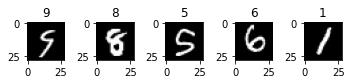

In [ ]:
from tensorflow.keras.datasets import mnist
(trainX, trainy), (testX, testy) = mnist.load_data()
print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))
for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

In [ ]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255
train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))
print (train_data.shape, test_data.shape)


(60000, 28, 28, 1) (10000, 28, 28, 1)


**ENCODER**

In [ ]:
import tensorflow
input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))
encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Flatten()(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

**LATENT DISTRIBUTION AND SAMPLING**

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random
 
distribution_mean = tensorflow.keras.layers.Dense(2, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [ ]:
encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 12, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 64)   36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

**DECODER**

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(2))
decoder = tensorflow.keras.layers.Dense(64)(decoder_input)
decoder = tensorflow.keras.layers.Reshape((1, 1, 64))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
 
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
 
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
 
decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [ ]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 64)          36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 5, 5, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 12, 12, 64)        3692

**BUILDING VAE**

In [ ]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
autoencoder = tensorflow.keras.models.Model(input_data, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 2)                 57652     
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         112577    
Total params: 170,229
Trainable params: 170,229
Non-trainable params: 0
_________________________________________________________________


**LOSS FUNCTION**

In [ ]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        #print('reconstruction_loss = {:.4f}'.format(reconstruction_loss_batch*28*28), end='\t')
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        #print('kl_loss= {:.4f}'.format(kl_loss_batch*(-0.5)), end='\t')
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

**TRAINING**

In [ ]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 2)                 57652     
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         112577    
Total params: 170,229
Trainable params: 170,229
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.fit(train_data, train_data, epochs=20, batch_size=64, validation_data=(test_data, test_data))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - ETA: 0s - loss: 42.6608

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 40s 673us/sample - loss: 42.6608 - val_loss: 38.7433
Epoch 2/20
60000/60000 [==============================] - 7s 124us/sample - loss: 37.8951 - val_loss: 36.7317
Epoch 3/20
60000/60000 [==============================] - 7s 125us/sample - loss: 36.6465 - val_loss: 36.5233
Epoch 4/20
60000/60000 [==============================] - 8s 125us/sample - loss: 36.0048 - val_loss: 35.9721
Epoch 5/20
60000/60000 [==============================] - 8s 125us/sample - loss: 35.5525 - val_loss: 35.5449
Epoch 6/20
60000/60000 [==============================] - 7s 124us/sample - loss: 35.1958 - val_loss: 35.6363
Epoch 7/20
60000/60000 [==============================] - 7s 125us/sample - loss: 34.9540 - val_loss: 34.9436
Epoch 8/20
60000/60000 [==============================] - 7s 125us/sample - loss: 34.7542 - val_loss: 34.7855
Epoch 9/20
60000/60000 [==============================] - 7s 124us/sample - loss: 34.5859 - val_loss: 34.7184
Epoch 10/20
60000/60

**RESULTS**

Real Test Images


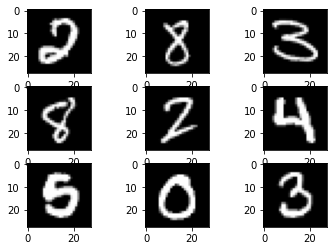

Reconstructed Images with Variational Autoencoder


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


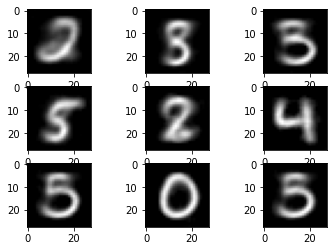

In [ ]:
offset=400
print ("Real Test Images")
# Real Images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_data[i+offset,:,:, -1], cmap='gray')
plt.show()

# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_data[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()